#HW1 – Text Classification with PyTorch (IMDB Dataset)

**Task:** Build a sentiment classifier for the IMDB dataset using PyTorch.  
**Dataset:** IMDB movie reviews.

**Hardware:** Google Colab.

I will implement:
1. Single-layer MLP
2. Two-layer MLP with hidden size 100
3. Two-layer MLP with hidden size 200

I will compare performance, plot test accuracy per epoch, and do error analysis. I have used tokenization, vocabulary building, training, evaluation, and misclassified examples. I have used SGD as optimizer.

1. Imports, Loading IMDB and Tokenize

In [ ]:
!pip install datasets transformers --quiet

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets import load_dataset
from collections import Counter
import matplotlib.pyplot as plt

# Load IMDB dataset
dataset = load_dataset("imdb")
train_data = dataset["train"]
test_data = dataset["test"]

# Base tokenizer as given
def tokenize(label, line):
    return line.split()

# Built vocab from training data
counter = Counter()
for example in train_data:
    counter.update(tokenize(None, example["text"]))

vocab = {word:i+1 for i,(word,freq) in enumerate(counter.most_common())}
vocab["<unk>"] = 0
vocab_size = len(vocab)
print(f"Vocab size: {vocab_size}")

# Text to index conversion
def text_pipeline(text):
    return [vocab.get(token, 0) for token in tokenize(None, text)]

# Dataset class
class IMDBDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        label = 0 if self.data[idx]["label"] == 0 else 1
        text = torch.tensor(text_pipeline(self.data[idx]["text"]), dtype=torch.int64)
        return label, text

Vocab size: 280618


2. Collate Function for EmbeddingBag

In [ ]:
def collate_batch(batch):
    labels = torch.tensor([label for label, text in batch], dtype=torch.int64)
    texts = [text for label, text in batch]
    offsets = [0] + [len(t) for t in texts[:-1]]
    offsets = torch.tensor(offsets).cumsum(dim=0)
    texts = torch.cat(texts)
    return labels, texts, offsets

# Dataloaders
batch_size = 64
train_loader = DataLoader(IMDBDataset(train_data), batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(IMDBDataset(test_data), batch_size=batch_size, shuffle=False, collate_fn=collate_batch)


3. MLP Model ( given base Code)

In [ ]:
class MLP(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class, hidden_dim=None):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        if hidden_dim is None:
            self.fc = nn.Linear(embed_dim, num_class)  # Single-layer
            self.fc1 = None
            self.fc2 = None
        else:
            self.fc1 = nn.Linear(embed_dim, hidden_dim) # Two-layer
            self.fc2 = nn.Linear(hidden_dim, num_class)
            self.fc = None
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        if self.fc is not None:
            self.fc.weight.data.uniform_(-initrange, initrange)
            self.fc.bias.data.zero_()
        if self.fc1 is not None:
            self.fc1.weight.data.uniform_(-initrange, initrange)
            self.fc1.bias.data.zero_()
            self.fc2.weight.data.uniform_(-initrange, initrange)
            self.fc2.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        if self.fc is not None:
            return self.fc(embedded)
        hidden = F.relu(self.fc1(embedded))
        return self.fc2(hidden)

4. Training and Evaluation Functions

In [ ]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, total_correct, total_count = 0,0,0
    for labels, texts, offsets in dataloader:
        labels, texts, offsets = labels.to(device), texts.to(device), offsets.to(device)
        optimizer.zero_grad()
        outputs = model(texts, offsets)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * labels.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
    return total_loss/total_count, total_correct/total_count

def evaluate(model, dataloader, criterion, device, save_misclassified=False):
    model.eval()
    total_loss, total_correct, total_count = 0,0,0
    misclassified = []
    with torch.no_grad():
        for labels, texts, offsets in dataloader:
            labels, texts, offsets = labels.to(device), texts.to(device), offsets.to(device)
            outputs = model(texts, offsets)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(1)
            total_correct += (preds == labels).sum().item()
            total_count += labels.size(0)
            if save_misclassified:
                for i in range(len(preds)):
                    if preds[i] != labels[i]:
                        misclassified.append((labels[i].item(), preds[i].item()))
    if save_misclassified:
        print("Number of misclassified samples:", len(misclassified))
    return total_loss/total_count, total_correct/total_count


5. Run Experiments

Hyper parameters defined here!

In [ ]:
device = torch.device("cpu")
embed_dim = 128
num_class = 2
epochs = 10
lr = 0.05

configs = {"Single layer": None, "Two layer-100 hidden": 100, "Two layer-200 hidden": 200}
results = {}

for name, hidden_dim in configs.items():
    print(f"\nTraining {name} MLP")
    model = MLP(vocab_size, embed_dim, num_class, hidden_dim).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    test_acc_history = []
    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)
        test_acc_history.append(test_acc)
        print(f"Epoch {epoch+1}: Train acc={train_acc:.4f}, Test acc={test_acc:.4f}")
    results[name] = test_acc_history



Training Single layer MLP
Epoch 1: Train acc=0.5180, Test acc=0.5327
Epoch 2: Train acc=0.5514, Test acc=0.5631
Epoch 3: Train acc=0.5789, Test acc=0.5793
Epoch 4: Train acc=0.5968, Test acc=0.5973
Epoch 5: Train acc=0.6110, Test acc=0.6119
Epoch 6: Train acc=0.6247, Test acc=0.6207
Epoch 7: Train acc=0.6281, Test acc=0.6277
Epoch 8: Train acc=0.6342, Test acc=0.6338
Epoch 9: Train acc=0.6405, Test acc=0.6350
Epoch 10: Train acc=0.6422, Test acc=0.6432

Training Two layer-100 hidden MLP
Epoch 1: Train acc=0.5596, Test acc=0.5903
Epoch 2: Train acc=0.6120, Test acc=0.6266
Epoch 3: Train acc=0.6374, Test acc=0.6366
Epoch 4: Train acc=0.6544, Test acc=0.6499
Epoch 5: Train acc=0.6681, Test acc=0.6674
Epoch 6: Train acc=0.6816, Test acc=0.6883
Epoch 7: Train acc=0.6954, Test acc=0.7002
Epoch 8: Train acc=0.7039, Test acc=0.7094
Epoch 9: Train acc=0.7150, Test acc=0.7180
Epoch 10: Train acc=0.7252, Test acc=0.7227

Training Two layer-200 hidden MLP
Epoch 1: Train acc=0.5845, Test acc=0.617

Single layer, Max accuracy: 0.6432

Hidden 100, Max accuracy: 0.7227

Hidden 200, Max accuracy: 0.7202

6. Plot Results

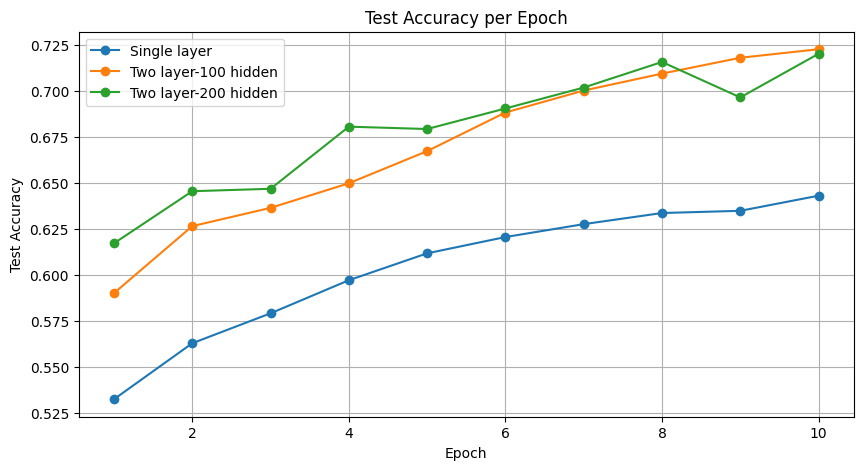

In [ ]:
plt.figure(figsize=(10,5))
for name, accs in results.items():
    plt.plot(range(1, epochs+1), accs, marker='o', label=name)
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy per Epoch")
plt.legend()
plt.grid(True)
plt.show()

7. Analysis

The two-layer MLP showed higher accuracy than the single-layer because it obviously can learn more complex, non-linear relationships because of the extra layer. It is like one  extra layer for more filtration/better analysis.

Hidden Dimension 100 vs 200:
Increasing hidden size from 100 to 200 inceases the accuracy for the 200 modelin the start. This is because more hidden neurons give the model more representational power. However after  during 9 , somethiing interesting emerges . While 100 model is stable, the 200 model has a great dip in accuracy. i cant figure out why yet but essentially for this problem, increasing neuron sin hidden layer didn't help.

Hyperparameters Used:

Embedding dim : 128

Hidden dim : 100 and 200

Batch size : 64

Epochs : 10

Learning rate : 0.05

8. Some Misclassified Examples

In [ ]:
# Function to decode indices back to words
inv_vocab = {idx: word for word, idx in vocab.items()}

def decode_text(text_tensor):
    return " ".join([inv_vocab.get(idx.item(), "<unk>") for idx in text_tensor])

# Evaluate on test set and get misclassified examples
for name, hidden_dim in configs.items():
    print(f"\nMisclassified examples for {name} MLP:")
    model = MLP(vocab_size, embed_dim, num_class, hidden_dim).to(device)
    # Load trained model weights if needed, here we assume model is trained in same session
    _, _ = evaluate(model, test_loader, criterion, device, save_misclassified=True)

    # Collect some misclassified examples
    misclassified_texts = []
    with torch.no_grad():
        for labels, texts, offsets in test_loader:
            labels, texts, offsets = labels.to(device), texts.to(device), offsets.to(device)
            outputs = model(texts, offsets)
            preds = outputs.argmax(1)
            for i in range(len(preds)):
                if preds[i] != labels[i] and len(misclassified_texts) < 5:
                    start = offsets[i].item() if i < len(offsets) else 0
                    end = offsets[i+1].item() if i+1 < len(offsets) else len(texts)
                    misclassified_texts.append((decode_text(texts[start:end]), labels[i].item(), preds[i].item()))
            if len(misclassified_texts) >= 5:
                break

    for idx, (text, true_label, pred_label) in enumerate(misclassified_texts):
        print(f"Example {idx+1}:")
        print(f"True label: {true_label}, Predicted: {pred_label}")
        print(f"Text: {text[:300]}...\n")  # show first 300 chars




Misclassified examples for Single layer MLP:
Number of misclassified samples: 12482
Example 1:
True label: 0, Predicted: 1
Text: I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually <unk> under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that ...

Example 2:
True label: 0, Predicted: 1
Text: its a totally average film with a few <unk> action sequences that make the plot seem a little better and remind the viewer of the classic van dam films. parts of the plot don't make sense and seem to be added in to use up time. the end plot is that of a very basic type that doesn't leave the viewer ...

Example 3:
True label: 0, Predicted: 1
Text: STAR RATING: ***** Saturday Night **** Friday Night *** Friday Morning ** Sunday Night * Monday Morning <br /><br />Former New Orleans homicide cop Jack <unk> (Jean Claud

For the misclassified samples, the model fails on long, rare words , sarcastic, or ambiguous reviews. it makes sense because we arent using an attention model to encode context , the model is just using word occurences to predict if its popsitive or negative.

for an instance, for one of these test cases, it has failed due to sarcasm and also too many positive words being mentioned.

 Text: I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually <unk> under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that ...